# Optimisation with `firedrake-adjoint`

*This example is modified from the equivalent [`dolfin-adjoint` demo](http://www.dolfin-adjoint.org/en/latest/documentation/stokes-bc-control/stokes-bc-control.html)*


In this example, we will look at how to use `firedrake-adjoint` to optimise for strong (Dirichlet) conditions in a steady problem.  `firedrake-adjoint` is a thin compatibility layer for the [`dolfin-adjoint` package](http://www.dolfin-adjoint.org/en/latest/), a python package to **automatically derive the discrete adjoint and tangent linear models** of forward problems written using Firedrake.

## Installing necessary dependencies

For the minimisation, we will need `scipy`, which is installed with

```sh
pip install scipy
```

In the activated firedrake virtualenv.

As usual, we begin with some notebook magic (so that plots appear nicely) and importing Firedrake.

In [2]:
%matplotlib notebook
import matplotlib.pyplot as plt
from firedrake import *

The next step is new, we now import the `firedrake.adjoint` package, which exposes the various names useful in inverse problems.

In [3]:
from firedrake.adjoint import *

We need to start taping (annotating) the Firedrake operations we run in order to be able to execute the adjoint.

In [4]:
continue_annotation()

True

## Problem setup
Now we will set up the problem.  We consider minimising the compliance:

$$
\min_{g, u, p} \ \frac{1}{2}\int_{\Omega} \nabla u \cdot \nabla u\,\text{d}x +  \frac{\alpha}{2} \int_{\Gamma_{\textrm{in}}} g^2\,\text{d}s
$$

subject to the Stokes equations
$$
\begin{split}-\nu \Delta u + \nabla p &= 0  \quad \text{in $\Omega$}, \\
                  \nabla \cdot u &= 0  \quad \text{in $\Omega$},  
                  \end{split}
$$

and Dirichlet conditions

$$
\begin{split}
u &= g  \quad \text{on $\Gamma_\text{circ}$}, \\
u &= f  \quad \text{on $\Gamma_\text{in}$}, \\
u &= 0  \quad \text{on $\Gamma_\text{top} \cup \Gamma_\text{bottom}$}, \\
p &= 0  \quad \text{on $\Gamma_\text{out}$}. \\
\end{split}
$$

Here, $u$ and $p$ are unknown velocity and pressure, $f$ is a prescribed inflow, $g$ is the control variable that we will optimise for and $\alpha$ is a regularisation parameter.  This corresponds physically to minimising the loss of energy as heat by controlling the in/outflow on $\Gamma_\text{circ}$.  The regularisation parameter penalises too many non-zero control values.

This problem setup requires a mesh that is more complex than the built in ones Firedrake provides.  Instead, it was created with [Gmsh](http://gmsh.info).  It is loaded by using the `Mesh` constructor, passing the filename of the mesh in question.

In [5]:
mesh = Mesh("stokes-control.msh")

Now we'll take a look at the mesh.  Since we will need to know which mesh markers correspond to which parts of the boundary, we've added a legend to the plot.  Normally you will know this because you told your mesh generator how to mark the boundaries.

In [6]:
# NBVAL_IGNORE_OUTPUT
fig, axes = plt.subplots()
triplot(mesh, axes=axes)
axes.axis("off")
axes.set_aspect("equal")
axes.legend(loc="upper right");

<IPython.core.display.Javascript object>

## The forward problem

The forward problem should be familiar by now, we create a mixed function space for $u$ and $p$ and set up trial and test functions.  We specify a parabolic velocity at the inflow, and no-slip (zero velocity) conditions on the side walls.  The zero-pressure outflow condition is enforced weakly.

Our variational formulation for Stokes reads as follows.  Find $(u, p) \in V\times Q$ such that:

$$
\begin{align}
\int_\Omega \nu \nabla u : \nabla v\,\text{d}x
- \int_\Omega p \nabla \cdot v\,\text{d}x 
- \int_{\Gamma_{\text{circ}}} \nu (\nabla u \cdot n) \cdot v\,\text{d}s  &= 0 \quad \forall v \in V,\\
- \int_\Omega q \nabla \cdot u\,\text{d}x &= 0 \quad \forall q \in Q.\\
u &= 0 \quad \text{on $\Gamma_{\text{top}} \cup \Gamma_{\text{bottom}}$},\\
u &= \left[\frac{y(10 - y)}{25}, 0\right]^T \quad \text{on $\Gamma_{\text{in}}$},\\
u &= g \quad \text{on $\Gamma_{\text{circ}}$},\\
\frac{\text{d}p}{\text{d}n} &= 0 \quad \text{on $\Gamma_{\text{out}}$}.
\end{align}
$$

In [7]:
V = VectorFunctionSpace(mesh, "Lagrange", 2)
Q = FunctionSpace(mesh, "Lagrange", 1)
W = V*Q

v, q = TestFunctions(W)
u, p = TrialFunctions(W)

nu = Constant(1)     # Viscosity coefficient

x, y = SpatialCoordinate(mesh)
u_inflow = as_vector([y*(10-y)/25.0, 0])

noslip = DirichletBC(W.sub(0), (0, 0), (3, 5))
inflow = DirichletBC(W.sub(0), interpolate(u_inflow, V), 1)
static_bcs = [inflow, noslip]

The boundary value, $g$, on the circle will be our control variable.  To do this, we define a `Function` which will hold the boundary values, we then build a `DirichletBC` object as normal.

In [8]:
g = Function(V, name="Control")
controlled_bcs = [DirichletBC(W.sub(0), g, 4)]
bcs = static_bcs + controlled_bcs

Now we define the bilinear and linear forms.

In [9]:
a = nu*inner(grad(u), grad(v))*dx - inner(p, div(v))*dx - inner(q, div(u))*dx
L = Constant(0)*q*dx

Now let's solve the forward problem so that `firedrake-adjoint` annotates it.  We'll also take a look at the solution.

In [10]:
w = Function(W)
solve(a == L, w, bcs=bcs, solver_parameters={"mat_type": "aij",
                                             "ksp_type": "preonly",
                                             "pc_type": "lu",
                                             "pc_factor_shift_type": "inblocks"})

In [11]:
# NBVAL_IGNORE_OUTPUT
u_init, p_init = w.subfunctions

fig, axes = plt.subplots(nrows=2, sharex=True, sharey=True)
streamlines = streamplot(u_init, resolution=1/3, seed=0, axes=axes[0])
fig.colorbar(streamlines, ax=axes[0], fraction=0.046)
axes[0].set_aspect("equal")
axes[0].set_title("Velocity")

contours = tricontourf(p_init, 30, axes=axes[1])
fig.colorbar(contours, ax=axes[1], fraction=0.046)
axes[1].set_aspect("equal")
axes[1].set_title("Pressure");

<IPython.core.display.Javascript object>

## The optimisation problem

Now we come to the optimisation problem.  We first define the functional we wish to minimise, this is done by assembling a form that produces a number.  Then we specify a control variable, and produce a "reduced" functional (the evaluation of the functional at a given control value).  We then minimise the functional, producing an optimised control value.  See [the dolfin-adjoint documentation](http://www.dolfin-adjoint.org/en/latest/documentation/) for more details on reduced functionals.

In [10]:
u, p = split(w)
alpha = Constant(10)

J = assemble(1./2*inner(grad(u), grad(u))*dx + alpha/2*inner(g, g)*ds(4))
m = Control(g)
Jhat = ReducedFunctional(J, m)

In order to see what is going on in the optimisation process, we can attach a progress bar class to the tape:

In [11]:
get_working_tape().progress_bar = ProgressBar

In [12]:
g_opt = minimize(Jhat)

Evaluating functional ▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣ 11/11 [0:00:00]
Evaluating adjoint ▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣ 11/11 [0:00:00]
Evaluating functional ▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣ 11/11 [0:00:00]
Evaluating adjoint ▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣ 11/11 [0:00:00]
Evaluating functional ▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣ 11/11 [0:00:00]
Evaluating adjoint ▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣ 11/11 [0:00:00]
Evaluating functional ▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣ 11/11 [0:00:00]
Evaluating adjoint ▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣ 11/11 [0:00:00]
Evaluating functional ▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣ 11/11 [0:00:00]
Evaluating adjoint ▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣ 11/11 [0:00:00]
Evaluating functional ▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣ 11/11 [0:00:00]
Evaluating adjoint ▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣

Now let's take a look at the optimised control.  The initial boundary condition on the circle was no slip.  We see now that the optimised boundary condition has a significant outflow in the hole.

<IPython.core.display.Javascript object>


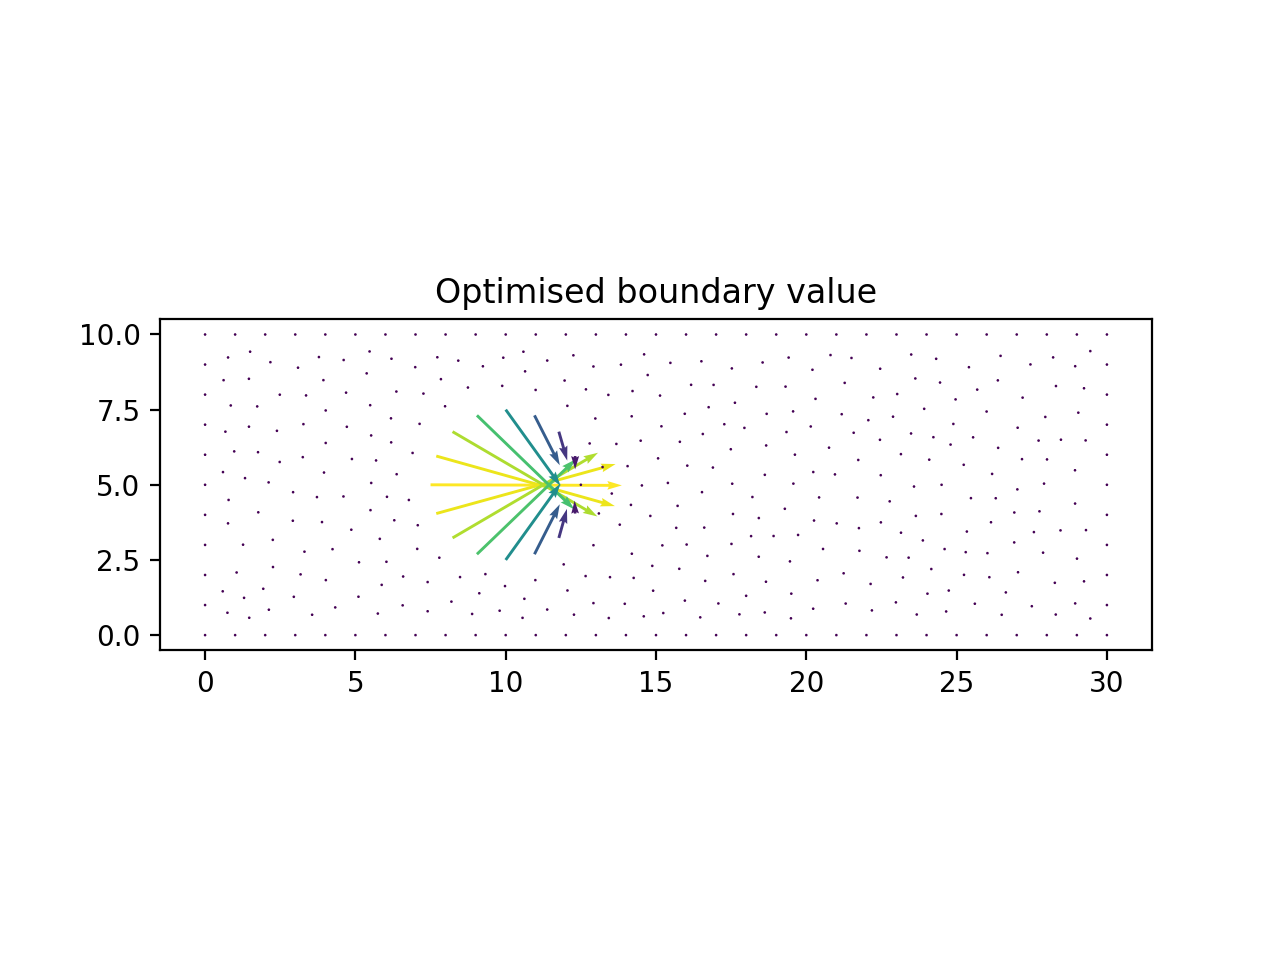

In [13]:
# NBVAL_IGNORE_OUTPUT
fig, axes = plt.subplots()
arrows = quiver(g_opt, axes=axes, scale=3)
axes.set_aspect("equal")
axes.set_title("Optimised boundary value");

Let's compare the difference in the initial and final values of the functional.  This is done by calling the `ReducedFunctional` object with the control at the requested value.

In [14]:
print("Jhat(g) = %.8g\nJhat(g_opt) = %.8g" % (Jhat(g), Jhat(g_opt)))

Evaluating functional ▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣ 12/12 [0:00:00]
Evaluating functional ▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣ 12/12 [0:00:00]

Jhat(g) = 46.078212
Jhat(g_opt) = 19.896719


To see the optimised flow field, we solve the same problem again, only with the new (optimised) value for the boundary data on $\Gamma_\text{circ}$.  This time we're not interested in annotating the solve, so we tell `firedrake-adjoint` to ignore it by passing `annotate=False`.

In [15]:
g.assign(g_opt)
w_opt = Function(W)
solve(a == L, w_opt, bcs=bcs, solver_parameters={"mat_type": "aij",
                                                 "ksp_type": "preonly",
                                                 "pc_type": "lu",
                                                 "pc_factor_shift_type": "inblocks"},
      annotate=False)

<IPython.core.display.Javascript object>


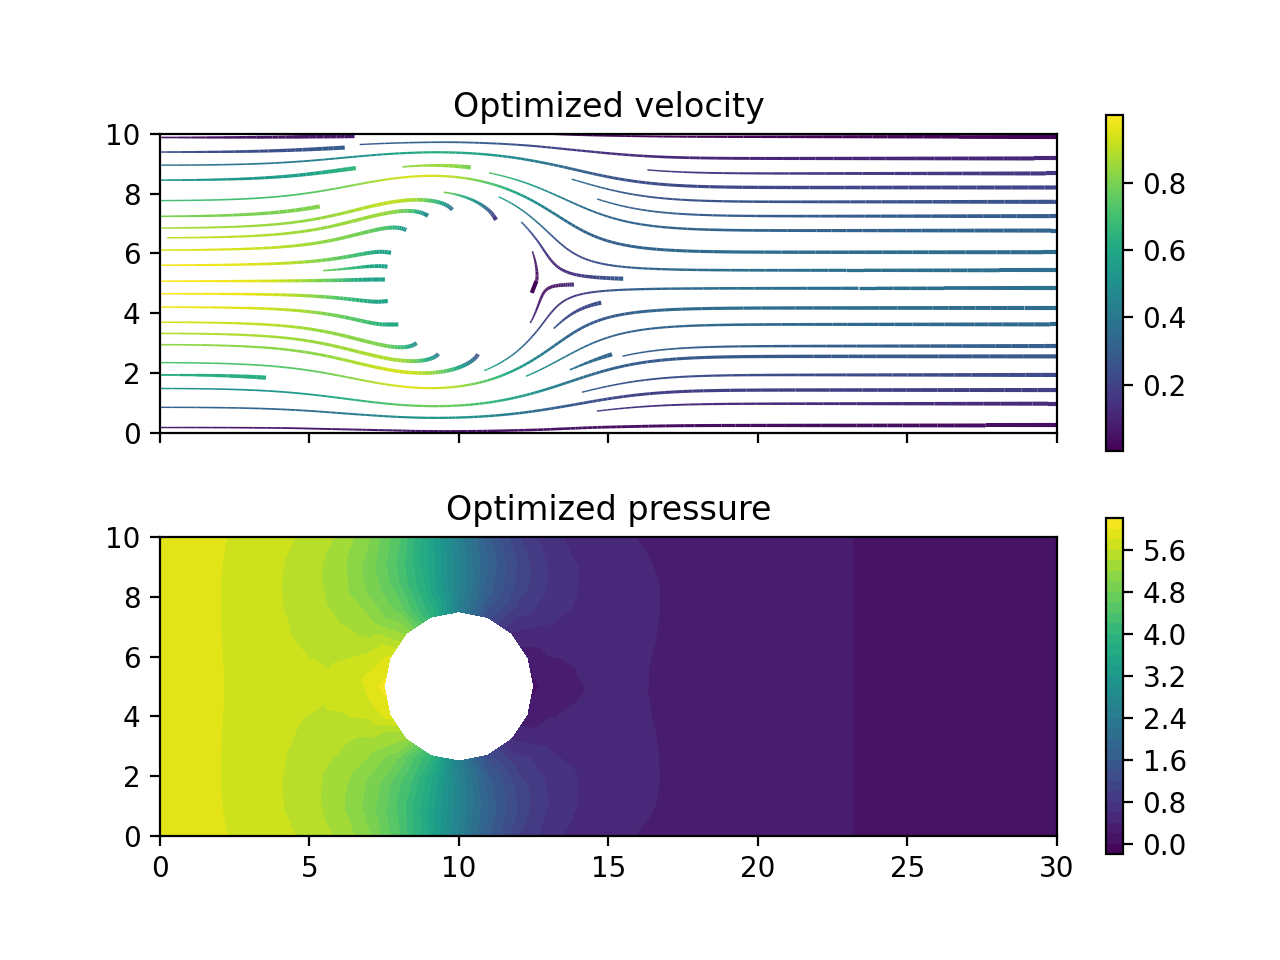

In [16]:
# NBVAL_IGNORE_OUTPUT
u_opt, p_opt = w_opt.subfunctions

fig, axes = plt.subplots(nrows=2, sharex=True, sharey=True)
streamlines = streamplot(u_opt, resolution=1/3, seed=0, axes=axes[0])
fig.colorbar(streamlines, ax=axes[0], fraction=0.046)
axes[0].set_aspect("equal")
axes[0].set_title("Optimized velocity")

contours = tricontourf(p_opt, 30, axes=axes[1])
fig.colorbar(contours, ax=axes[1], fraction=0.046)
axes[1].set_aspect("equal")
axes[1].set_title("Optimized pressure");

Now that we are done optimising this problem, and so that the recorded annotations do not leak into the exercise, we tell `firedrake-adjoint` to *forget* all of the entries on its tape.

In [17]:
tape = get_working_tape()
tape.clear_tape()

## Exercise:

Go back to the start of the notebook and consider a different inflow velocity. For example, try
$$u = \left[\frac{y^2(10 - y)}{125}, 0\right]^T \quad \text{on} \quad \Gamma_{\text{in}}.$$

How does it affect the solution before and after optimisation? 